# Setup

In [ ]:
!nvidia-smi
%pip install --quiet ftfy regex tqdm kornia git+https://github.com/openai/CLIP.git
%mkdir -p figs

Tue Jun 14 12:13:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.11.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install --quiet fvcore iopath
        !pip install --quiet --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install --quiet 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     |████████████████████████████████| 50 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 7.7 MB/s 
     |████████████████████████████████| 43.2 MB 658 kB/s 


In [ ]:
import torch
import clip
from PIL import Image
from glob import glob
import numpy as np
from matplotlib import lines, pyplot as plt
import os
from tqdm.notebook import tqdm
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision.transforms import Compose, Normalize, Resize, InterpolationMode, ToTensor, CenterCrop
import pytorch3d
import imageio
from skimage import img_as_ubyte
np.set_printoptions(precision=4, suppress=True)

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    AmbientLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [ ]:
from pytorch3d.structures import join_meshes_as_scene
from pytorch3d.renderer.lighting import AmbientLights
from pytorch3d.transforms import euler_angles_to_matrix

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
#R, T = look_at_view_transform(2, 40, 180) 
#cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 1.0, 0.0]])
#lights = AmbientLights(ambient_color=[1,1,1], device=device)

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer3d = lambda cameras: MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

# load/transform cow
#raw_cow_mesh = load_objs_as_meshes(["meshes/cow.obj"], device=device)
#raw_cow_mesh.scale_verts_(0.65)
raw_cow_mesh = load_objs_as_meshes(["meshes/cow.obj"], device=device)
raw_cow_mesh.scale_verts_(0.5)
rotmat = euler_angles_to_matrix(torch.tensor([0,0,0])*(torch.pi/180.0), convention='XYZ').to(device)

raw_cow_mesh = raw_cow_mesh.update_padded(raw_cow_mesh.verts_padded() @ rotmat)
# load/transform table
raw_table_mesh = load_objs_as_meshes(["meshes/woodtable.obj"], device=device)
raw_table_mesh.scale_verts_(0.9)
raw_table_mesh.offset_verts_(torch.tensor([0.15,-1.2,0.2], device=device))

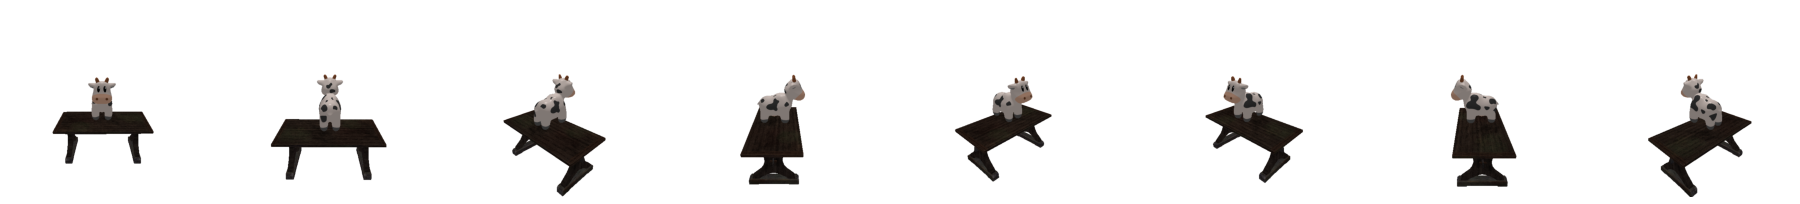

In [ ]:
default_cam = (3,20,180)
class BaseRenderer(nn.Module):
    def __init__(self):
      super().__init__()
    def debug(self, camera_params=[default_cam]):
      images = self.forward(camera_params)
      plt.figure(figsize=(4*len(images),4))
      for i,im in enumerate(images):
        plt.subplot(1,len(images),i+1)
        plt.imshow(im.permute((1,2,0)).cpu().detach())
        plt.axis('off')
      plt.show()

class CowRendererSingle(BaseRenderer):
  def __init__(self, s=0):
    super().__init__()
    self.s = nn.Parameter(torch.Tensor([s]))
    self.description = 'y-translation'
    self.trans_scales = torch.tensor([1.75,1.75,1.75]).to(device)

  def forward(self, camera_params=[default_cam]):
    #trans = torch.tensor([0,self.s,0]).tanh().reshape(1,1,3).to(device)
    trans = self.trans_scales*(torch.stack([
                         torch.tensor([0], device=device),
                         self.s,
                         torch.tensor([0], device=device),
    ]).tanh()).reshape(1,1,3)
    #cow_mesh_t = raw_cow_mesh.offset_verts(trans) 
    cow_mesh_t = raw_cow_mesh.clone()
    cow_mesh_t = cow_mesh_t.update_padded(cow_mesh_t.verts_padded() + trans)
    all_meshes = join_meshes_as_scene(
        [cow_mesh_t, raw_table_mesh],
        include_textures=True
    )
    lavs = [look_at_view_transform(*C) for C in camera_params]
    return torch.stack([
                        renderer3d(FoVPerspectiveCameras(R=R,T=T,device=device))(all_meshes)[0,:,:,:3].permute((2,0,1))
                        for R,T in lavs
    ])


class CowRenderer(BaseRenderer):
  def __init__(self, s=[0,0,0,0,0,0,0]):
    super().__init__()
    self.s = nn.Parameter(torch.Tensor(s))
    self.param_names = ['scale', 'x-rotation', 'y-rotation', 'z-rotation', 'x-translation', 'y-translation', 'z-translation']
    self.trans_scales = torch.tensor([1.75,1.75,1.75]).to(device)

  def forward(self, camera_params=[default_cam]):
    trans = self.trans_scales*(self.s[-3:].tanh()).reshape(1,1,3)
    rotmat = euler_angles_to_matrix(torch.pi*self.s[1:4].tanh(), convention='XYZ').to(device)
    cow_mesh_t = raw_cow_mesh.clone()
    cow_mesh_t = cow_mesh_t.update_padded((2*self.s[0].sigmoid() * cow_mesh_t.verts_padded())@rotmat + trans)
    #cow_mesh_t.scale_verts_(2*self.s[0].sigmoid().item())

    # merge meshes into one
    all_meshes = join_meshes_as_scene(
        [cow_mesh_t, raw_table_mesh],
        include_textures=True
    )

    lavs = [look_at_view_transform(*C) for C in camera_params]
    return torch.stack([
                        renderer3d(FoVPerspectiveCameras(R=R,T=T,device=device))(all_meshes)[0,:,:,:3].permute((2,0,1))
                        for R,T in lavs
    ])
    #del cow_mesh_t
    #torch.cuda.empty_cache()
C_params = [
            (3,20,180),
            (3,20,0),
            (3,20,45),
            (3,20,90),
            (3,20,135),
            (3,20,225),
            (3,20,270),
            (3,20,315),
]
CowRendererSingle(0).to(device).debug(C_params)
#CowRenderer([0,0,0,0,0,0,0]).to(device).debug(C_params)

In [ ]:
import clip
#model_name = "ViT-B/16"
#model_name = "RN50"
model_name = "ViT-L/14"
model, preprocess = clip.load(model_name, device=torch.device("cpu"))
model = model.to(device)
model.eval()
p = Compose([t for t in preprocess.transforms if not ('ToTensor' in str(t) or '_convert_image' in str(t))])

renderer_class = CowRenderer
text_prompts = ["a cow floating directly above a table"]
#text_prompts = ["a cow sitting under a table"]
#text_prompts = ["a palm plant placed on a table"]
text_features = model.encode_text(clip.tokenize(text_prompts).to(device)).detach()
text_features_norm = text_features/text_features.norm(dim=-1).unsqueeze(-1)

def loss_fn(im, text_enc_norm):
    im_enc = model.encode_image(p(im))
    im_enc_norm = im_enc / im_enc.norm(dim=-1).unsqueeze(-1)
    return -(im_enc_norm@text_enc_norm.T).squeeze()

# CLIP sanity check

In [ ]:
subject = "cow floating above a table"
example_prompts = [
    #"a cow sitting far below a table",
    #"a cow floating directly above a table"
    f"itap of a {subject}.",
    f"a bad photo of the {subject}.",
    f"a origami {subject}.",
    f"a photo of the large {subject}.",
    f"a {subject} in a video game.",
    f"art of the {subject}.",
    f"a photo of the small {subject}."
]
rc = CowRendererSingle
bg=True

S = np.linspace(-2,2,100)
#with torch.no_grad():
text_enc = model.encode_text(clip.tokenize(example_prompts).to(device))
text_enc_norm = text_enc / text_enc.norm(dim=-1).unsqueeze(-1)
all_losses = []
all_gradients = []
for s in tqdm(S):
  renderer = rc(s).to(device)
  p_im = p(renderer())
  image_enc = model.encode_image(p_im)
  image_enc_norm = image_enc / image_enc.norm(dim=-1).unsqueeze(-1)
  loss = -text_enc_norm@image_enc_norm.T
  #loss.backward()
  all_losses.append(loss)
  del image_enc, image_enc_norm, loss, renderer, p_im
  torch.cuda.empty_cache()
all_losses = torch.stack(all_losses)
all_gradients = torch.stack(all_gradients)

fig = plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
for prompt,losses in zip(example_prompts, all_losses.T):
    plt.plot(S, losses, 'o-', label='"%s"' % prompt, zorder=1)
    i_opt = losses.argmin()
    plt.scatter(S[i_opt], losses[i_opt], marker='*', edgecolor='black', linewidth=2, s=450, zorder=5)
plt.ylabel('CLIP loss')
plt.title('Loss landscape for cow %s\n(CLIP model = %s)' % (rc().description, model_name))
plt.legend()
ax_loss = plt.gca()

for i,(prompt,losses) in enumerate(zip(example_prompts, all_losses.T)):
    plt.subplot(2,len(example_prompts),len(example_prompts)+i+1)
    i_opt = losses.argmin()
    im_opt = rc(S[i_opt]).to(device)().cpu()[0].permute((1,2,0)).detach()
    plt.axis('off')
    #plt.title('"%s"\n(s = %.2f)' % (prompt, S[i_opt]))
    plt.imshow(im_opt, zorder=5)
    ax_im = plt.gca()
    
    transFigure = fig.transFigure.inverted()
    coord1 = transFigure.transform(ax_loss.transData.transform([S[i_opt], losses[i_opt]]))
    coord2 = transFigure.transform(ax_im.transData.transform([im_opt.shape[1]/2, 0]))
    line = lines.Line2D(
        (coord1[0], coord2[0]),  # xdata
        (coord1[1], coord2[1]),  # ydata
        transform=fig.transFigure,
        color="grey",
        zorder=1
    )
    fig.lines.append(line)

plt.savefig('figs/3_3-cow-translation-optimal-images.pdf', bbox_inches='tight')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: ignored

# Single parameter

In [ ]:
S = np.linspace(-2,2,100)
all_losses = []
all_gradients = []

for s in tqdm(S, desc='computing all gradients'):
  renderer = CowRendererSingle(s=s).to(device)
  augmented_images = p(renderer())

  image_features = model.encode_image(augmented_images).squeeze()
  image_features_norm = image_features / image_features.norm(dim=-1).unsqueeze(-1)
  loss = -torch.mean(text_features_norm@image_features_norm.T)
  loss.backward()
  all_losses.append(loss.detach().cpu().item())
  all_gradients.append(renderer.s.grad.detach().item())
  del image_features
  del image_features_norm
  del augmented_images

torch.cuda.empty_cache();

computing all gradients:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

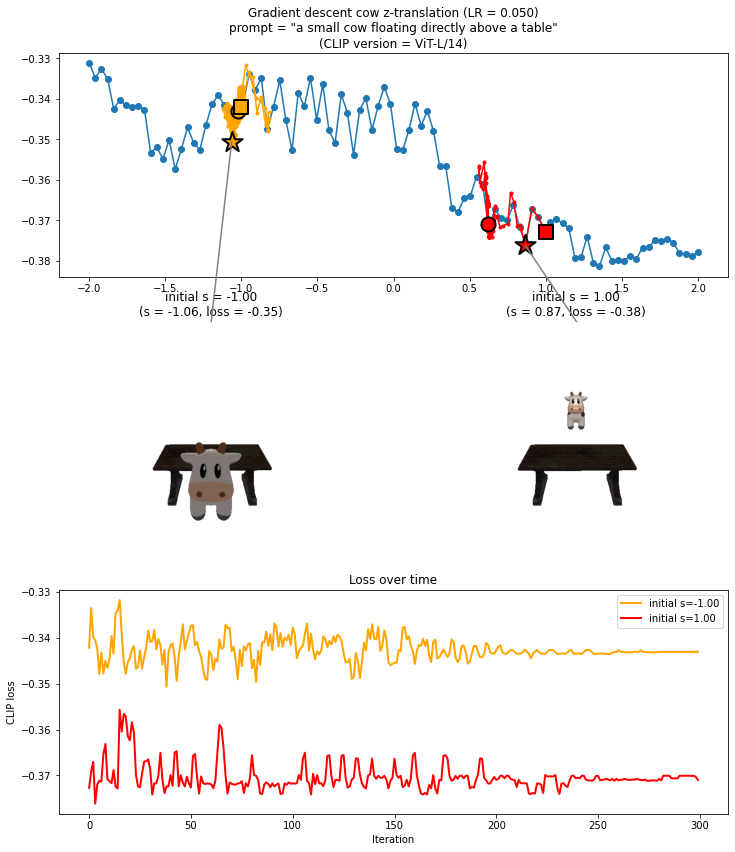

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR, CosineAnnealingWarmRestarts
from collections import defaultdict

lr = 0.05

gd_losses = defaultdict(list)
s_values = defaultdict(list)
gradients = defaultdict(list)

for s_init in [-1, 1.0]: # , 0.0, 1.0]:
  lr_steps = []
  #images_for_gif = []
  text_features = model.encode_text(clip.tokenize(text_prompts).to(device)).detach()
  text_features /= text_features.norm(dim=-1).unsqueeze(-1)

  #param_values = defaultdict(list)
  #gradients = defaultdict(list)
  renderer = CowRendererSingle(s=s_init).to(device)
  epochs = np.arange(300)
  optimizer = optim.Adam(renderer.parameters(), lr=lr)
  scheduler = CosineAnnealingLR(optimizer, T_max=len(epochs), eta_min=0.001)
  #scheduler = MultiStepLR(optimizer, gamma=0.5, milestones=[5,10,20,40])
  #scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=15, eta_min=0.01)
  t = tqdm(epochs)

  model.eval()
  for epoch in t:
      optimizer.zero_grad()
      #images_for_gif.append(ToPILImage()(im))
      augmented_images = p(renderer())

      # forward pass
      image_features = model.encode_image(augmented_images).squeeze()
      image_features_norm = image_features / image_features.norm(dim=-1).unsqueeze(-1)
      loss = -torch.mean(text_features@image_features_norm.T)

      # backprop
      loss.backward()

      # log info
      gd_losses[s_init].append(loss.detach().cpu().item())
      s_values[s_init].append(renderer.s.detach().item())
      gradients[s_init].append(renderer.s.grad.detach().item())

      # step
      optimizer.step()
      lr_steps.append(scheduler.get_last_lr())
      scheduler.step()
      del image_features
      del image_features_norm
      # update info
      t.set_description('s_init=%.2f, loss=%.2f, s=%.2f' % (s_init, loss, s_values[s_init][-1]), refresh=True)

del text_features
torch.cuda.empty_cache();

fig = plt.figure(figsize=(12,14))

# loss landscape
plt.subplot(3,1,1)
plt.plot(S, all_losses, 'o-')
colors = ['orange', 'red', 'green']
for s_init,color in zip(s_values.keys(), colors):
  # best epoch
  best_epoch = np.argmin(gd_losses[s_init])
  plt.scatter(s_values[s_init][best_epoch], gd_losses[s_init][best_epoch], marker='*', edgecolor='black', linewidth=2, s=450, zorder=5, color=color)
  # GD path
  plt.scatter(s_values[s_init][-1], gd_losses[s_init][-1], marker='o', edgecolor='black', linewidth=2, s=200, zorder=5, color=color)
  plt.scatter(s_values[s_init][0], gd_losses[s_init][0], marker='s', edgecolor='black', linewidth=2, s=200, zorder=5, color=color)
  plt.plot(s_values[s_init], gd_losses[s_init], '.-', color=color, label='initial s = %.2f' % s_init)
#plt.legend()
plt.title(
    r'Gradient descent cow %s (LR = %.3f)' % (CowRendererSingle().description, lr)
    + '\nprompt = "%s"\n(CLIP version = %s)' % (text_prompts[0], model_name)
)
ax_loss = plt.gca()


for i,k in enumerate(s_values.keys()):
    plt.subplot(3,len(s_values),1*len(s_values)+i+1)

    i_opt = np.argmin(gd_losses[k])
    im_opt = CowRendererSingle(s_values[k][i_opt]).to(device)().cpu()[0].permute((1,2,0)).detach()
    plt.axis('off')
    plt.title('initial s = %.2f\n(s = %.2f, loss = %.2f)' % (k, s_values[k][i_opt], gd_losses[k][i_opt]))
    plt.imshow(im_opt, zorder=5)
    ax_im = plt.gca()
    
    transFigure = fig.transFigure.inverted()
    coord1 = transFigure.transform(ax_loss.transData.transform([s_values[k][i_opt], gd_losses[k][i_opt]]))
    coord2 = transFigure.transform(ax_im.transData.transform([im_opt.shape[1]/2, 0]))
    line = lines.Line2D(
        (coord1[0], coord2[0]),  # xdata
        (coord1[1], coord2[1]),  # ydata
        transform=fig.transFigure,
        color="grey",
        zorder=1
    )
    fig.lines.append(line)

plt.subplot(3,1,3)
for k,color in zip(s_values.keys(), colors):
  plt.plot(epochs, gd_losses[k], lw=2, label='initial s=%.2f' % k, color=color)
  plt.xlabel('Iteration')
  plt.ylabel('CLIP loss')
  plt.title('Loss over time')
  plt.legend()

#plt.subplot(3,1,4)
#plt.plot(S, np.array(all_gradients), 'o-', lw=3, label=r'Gradient', alpha=1.0, color='orange')
#plt.title(r'Gradient values $\frac{\partial L}{\partial s}$')
#plt.xlabel('s (%s)' % renderer.description)
#plt.ylabel(r'Gradient')
#plt.axhline(y=0.0, color='grey', linestyle='-', alpha=1.0, zorder=1)

#plt.tight_layout()
plt.savefig('figs/3_3-cow-vanilla-gd.pdf', bbox_inches='tight')
plt.show()

# Single parameter - Novel view augmentation

In [ ]:
S = np.linspace(-2,2,100)
all_losses = []
all_gradients = []

with torch.no_grad():
  for s in tqdm(S, desc='computing all gradients'):
    renderer = CowRendererSingle(s=s).to(device)
    augmented_images = p(renderer(C_params))

    image_features = model.encode_image(augmented_images).squeeze()
    image_features_norm = image_features / image_features.norm(dim=-1).unsqueeze(-1)
    scores = text_features_norm@image_features_norm.T
    loss = -( torch.mean(scores) )
    # loss = -torch.mean(text_features_norm@image_features_norm.T)
    all_losses.append(loss.detach().cpu().item())
    #loss.backward()
    #all_gradients.append(renderer.s.grad.detach().item())
    del image_features
    del image_features_norm
    del augmented_images
torch.cuda.empty_cache();

computing all gradients:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

TypeError: ignored

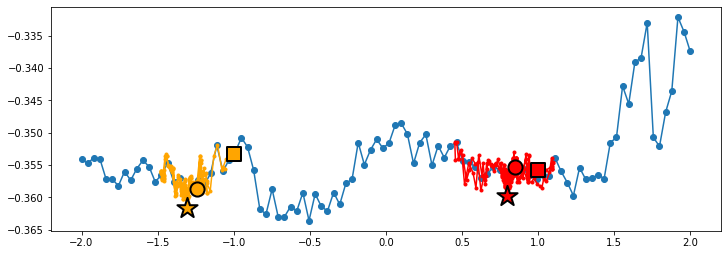

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR, CosineAnnealingWarmRestarts
from collections import defaultdict

lr = 0.05

gd_losses = defaultdict(list)
s_values = defaultdict(list)
gradients = defaultdict(list)

for s_init in [-1, 1.0]: # , 0.0, 1.0]:
  lr_steps = []
  #images_for_gif = []
  text_features = model.encode_text(clip.tokenize(text_prompts).to(device)).detach()
  text_features /= text_features.norm(dim=-1).unsqueeze(-1)

  #param_values = defaultdict(list)
  #gradients = defaultdict(list)
  renderer = CowRendererSingle(s=s_init).to(device)
  epochs = np.arange(300)
  optimizer = optim.Adam(renderer.parameters(), lr=lr)
  scheduler = CosineAnnealingLR(optimizer, T_max=len(epochs), eta_min=0.001)
  #scheduler = MultiStepLR(optimizer, gamma=0.5, milestones=[5,10,20,40])
  #scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=15, eta_min=0.01)
  t = tqdm(epochs)

  model.eval()
  for epoch in t:
      optimizer.zero_grad()
      augmented_images = p(renderer(C_params))

      # forward pass
      image_features = model.encode_image(augmented_images).squeeze()
      image_features_norm = image_features / image_features.norm(dim=-1).unsqueeze(-1)
      loss = -torch.mean(text_features@image_features_norm.T)

      # backprop
      loss.backward()

      # log info
      gd_losses[s_init].append(loss.detach().cpu().item())
      s_values[s_init].append(renderer.s.detach().item())
      gradients[s_init].append(renderer.s.grad.detach().item())

      # step
      optimizer.step()
      lr_steps.append(scheduler.get_last_lr())
      scheduler.step()
      del image_features
      del image_features_norm
      # update info
      t.set_description('s_init=%.2f, loss=%.2f, s=%.2f' % (s_init, loss, s_values[s_init][-1]), refresh=True)

del text_features
torch.cuda.empty_cache();

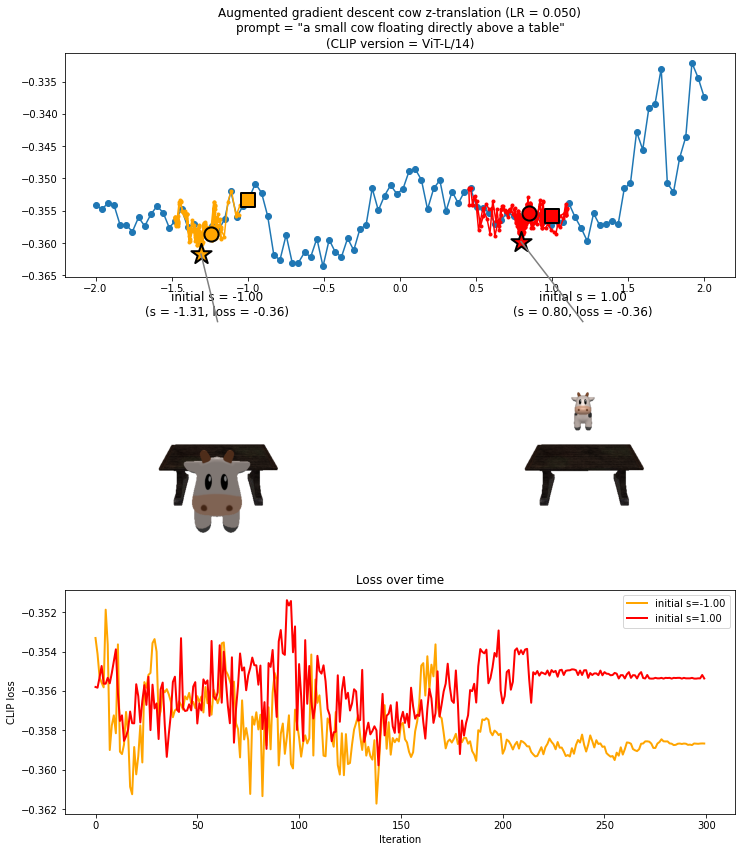

In [ ]:
fig = plt.figure(figsize=(12,14))

# loss landscape
plt.subplot(3,1,1)
plt.plot(S, all_losses, 'o-')
colors = ['orange', 'red', 'green']
for s_init,color in zip(s_values.keys(), colors):
  # best epoch
  best_epoch = np.argmin(gd_losses[s_init])
  plt.scatter(s_values[s_init][best_epoch], gd_losses[s_init][best_epoch], marker='*', edgecolor='black', linewidth=2, s=450, zorder=5, color=color)
  # GD path
  plt.scatter(s_values[s_init][-1], gd_losses[s_init][-1], marker='o', edgecolor='black', linewidth=2, s=200, zorder=5, color=color)
  plt.scatter(s_values[s_init][0], gd_losses[s_init][0], marker='s', edgecolor='black', linewidth=2, s=200, zorder=5, color=color)
  plt.plot(s_values[s_init], gd_losses[s_init], '.-', color=color, label='initial s = %.2f' % s_init)
#plt.legend()
plt.title(
    r'Augmented gradient descent cow %s (LR = %.3f)' % (CowRendererSingle().description, lr)
    + '\nprompt = "%s"\n(CLIP version = %s)' % (text_prompts[0], model_name)
)
ax_loss = plt.gca()


for i,k in enumerate(s_values.keys()):
    plt.subplot(3,len(s_values),1*len(s_values)+i+1)

    i_opt = np.argmin(gd_losses[k])
    im_opt = CowRendererSingle(s_values[k][i_opt]).to(device)().cpu()[0].permute((1,2,0)).detach()
    plt.axis('off')
    plt.title('initial s = %.2f\n(s = %.2f, loss = %.2f)' % (k, s_values[k][i_opt], gd_losses[k][i_opt]))
    plt.imshow(im_opt, zorder=5)
    ax_im = plt.gca()
    
    transFigure = fig.transFigure.inverted()
    coord1 = transFigure.transform(ax_loss.transData.transform([s_values[k][i_opt], gd_losses[k][i_opt]]))
    coord2 = transFigure.transform(ax_im.transData.transform([im_opt.shape[1]/2, 0]))
    line = lines.Line2D(
        (coord1[0], coord2[0]),  # xdata
        (coord1[1], coord2[1]),  # ydata
        transform=fig.transFigure,
        color="grey",
        zorder=1
    )
    fig.lines.append(line)

plt.subplot(3,1,3)
for k,color in zip(s_values.keys(), colors):
  plt.plot(epochs, gd_losses[k], lw=2, label='initial s=%.2f' % k, color=color)
  plt.xlabel('Iteration')
  plt.ylabel('CLIP loss')
  plt.title('Loss over time')
  plt.legend()
#plt.tight_layout()
plt.savefig('figs/3_3-cow-aug-gd.pdf', bbox_inches='tight')
plt.show()

-1


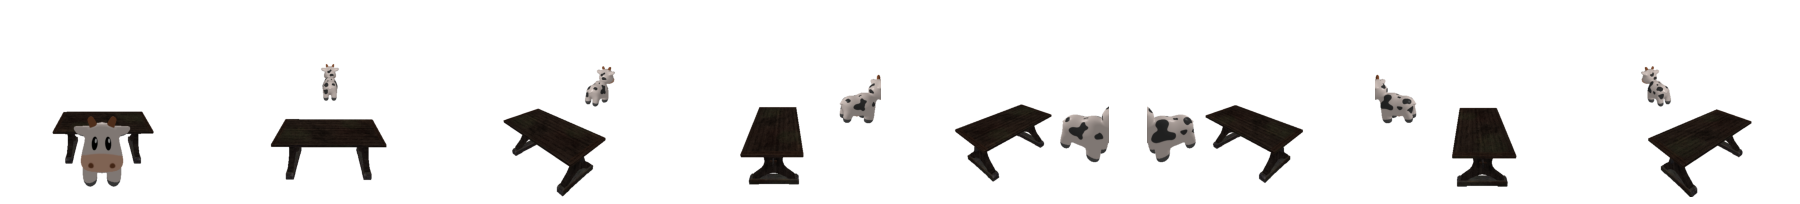

1.0


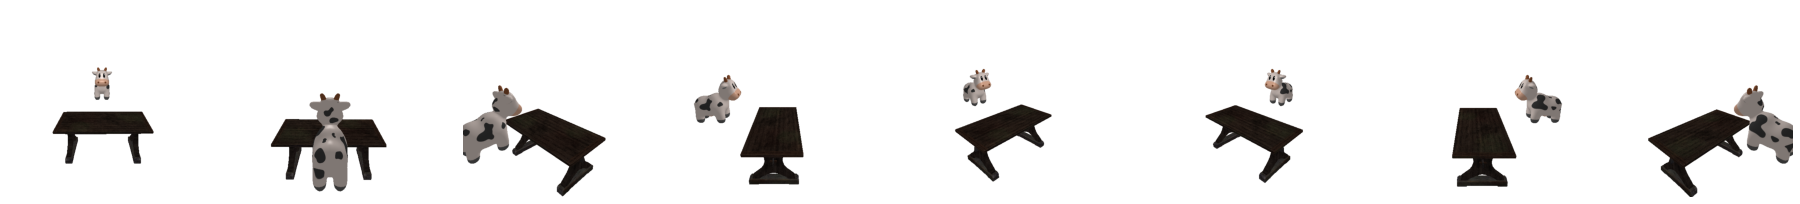

global minimum = -0.5


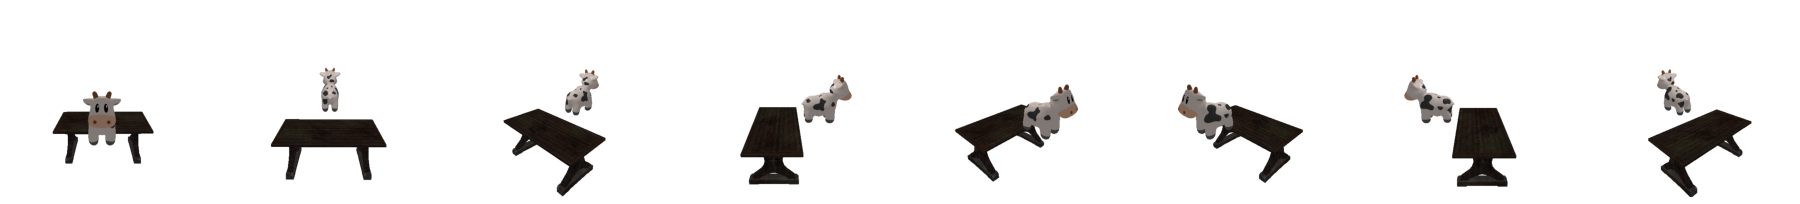

In [ ]:
for i,k in enumerate(s_values.keys()):
    print(k)
    i_opt = np.argmin(gd_losses[k])
    CowRendererSingle(s_values[k][i_opt]).to(device).debug(C_params)
print('global minimum = -0.5')
CowRendererSingle(-0.5).to(device).debug(C_params)

# Multiparam - No augmentation

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision.transforms import ToPILImage
# params
lr = 0.01

# collectors
gd_losses = []
s_values = []
gradients = []

epochs = np.arange(300)
renderer = CowRenderer([0,0,0,0,0,0,0]).to(device)
optimizer = optim.Adam(renderer.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=len(epochs), eta_min=0.001)

images_for_gif = []
#model.eval()
t = tqdm(epochs)
for epoch in t:
  optimizer.zero_grad()

  # render im
  im = renderer()[0]
  images_for_gif.append(ToPILImage()(im))
  image_features = model.encode_image(p(im).unsqueeze(0))
  image_features_norm = image_features / image_features.norm(dim=-1).unsqueeze(-1)

  # compute loss + gradients
  loss = torch.squeeze(-image_features_norm@text_features_norm.T)
  loss.backward()

  # log info
  gd_losses.append(loss.detach().cpu().item())
  s_values.append(renderer.s.detach().cpu().numpy())
  gradients.append(renderer.s.grad.detach().cpu().numpy())

  optimizer.step()
  scheduler.step()
  t.set_description('loss=%.3f, s=%s' % (gd_losses[-1], s_values[-1]), refresh=True)
del im
del image_features
del image_features_norm
torch.cuda.empty_cache()
s_values = np.array(s_values)

  0%|          | 0/300 [00:00<?, ?it/s]

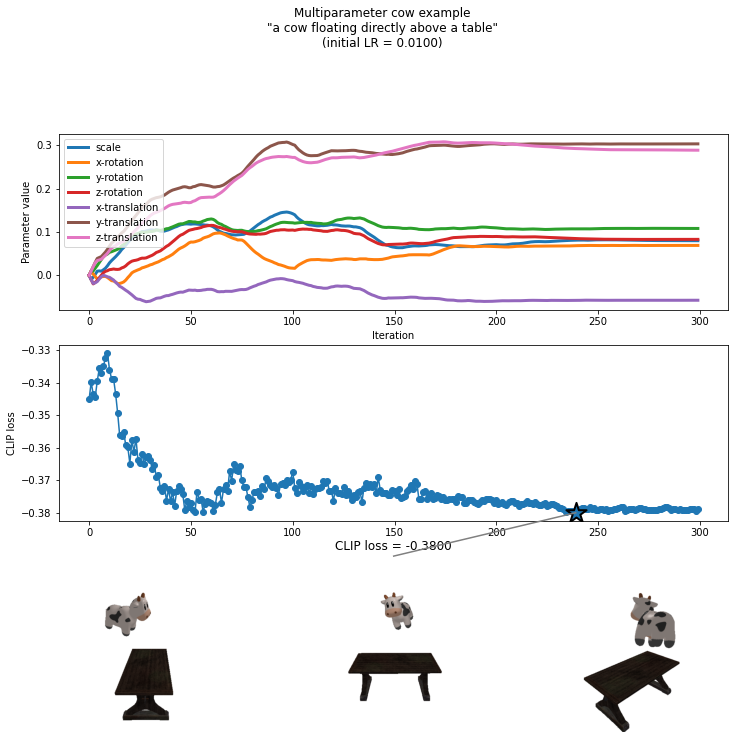

In [ ]:
import matplotlib.lines
fig = plt.figure(figsize=(12,11))

plt.subplot(3,1,1)
for s_v,label in zip(s_values.T, renderer.param_names):
  plt.plot(epochs, s_v, label=label, lw=3)
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

plt.subplot(3,1,2)
i_opt = np.argmin(gd_losses)
plt.plot(epochs, gd_losses, 'o-')
plt.scatter(epochs[i_opt], gd_losses[i_opt], marker='*', edgecolor='black', linewidth=2, s=450, zorder=5)
#plt.xlabel('Iteration')
plt.ylabel('CLIP loss')
ax_loss = plt.gca()

for i,j in enumerate([3,0,7]):
  plt.subplot(3,3,6+i+1)
  im_opt = renderer_class(s=s_values[i_opt]).to(device)(C_params)[j]
  plt.imshow(im_opt.permute((1,2,0)).detach().cpu())
  plt.axis('off')
  if j == 0:
    plt.title('CLIP loss = %.4f' % gd_losses[i_opt])
    ax_im = plt.gca()

transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(ax_loss.transData.transform([epochs[i_opt], gd_losses[i_opt]]))
coord2 = transFigure.transform(ax_im.transData.transform([im_opt.shape[2]/2, 0]))
line = lines.Line2D(
    (coord1[0], coord2[0]),  # xdata
    (coord1[1], coord2[1]),  # ydata
    transform=fig.transFigure,
    color="grey",
    zorder=1
)
fig.lines.append(line)

plt.suptitle(
    'Multiparameter cow example\n'
    '"%s"\n'
    r'(initial LR = %.4f)' % (text_prompts[0], lr)
    , y=1.04)
#plt.tight_layout()
plt.savefig('figs/3_3-loss-graph.pdf', bbox_inches='tight')
plt.show()

# Multiparam - Novel view augmentation

In [ ]:
from torchvision.transforms import ToPILImage
# params
lr = 0.01

# collectors
gd_losses = []
s_values = []
gradients = []

epochs = np.arange(300)
renderer = CowRenderer([0,0,0,0,0,0,0]).to(device)
optimizer = optim.Adam(renderer.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=len(epochs), eta_min=0.001)

images_for_gif = []
#model.eval()
t = tqdm(epochs)
for epoch in t:
  optimizer.zero_grad()

  # render im
  im = renderer(C_params)
  images_for_gif.append(ToPILImage()(im[0]))
  image_features = model.encode_image(p(im))
  image_features_norm = image_features / image_features.norm(dim=-1).unsqueeze(-1)

  # compute loss + gradients
  loss = torch.mean(-image_features_norm@text_features_norm.T)
  loss.backward()

  # log info
  gd_losses.append(loss.detach().cpu().item())
  s_values.append(renderer.s.detach().cpu().numpy())
  gradients.append(renderer.s.grad.detach().cpu().numpy())

  optimizer.step()
  scheduler.step()
  t.set_description('loss=%.3f, s=%s' % (gd_losses[-1], s_values[-1]), refresh=True)
del im
del image_features
del image_features_norm
torch.cuda.empty_cache()
s_values = np.array(s_values)

  0%|          | 0/300 [00:00<?, ?it/s]

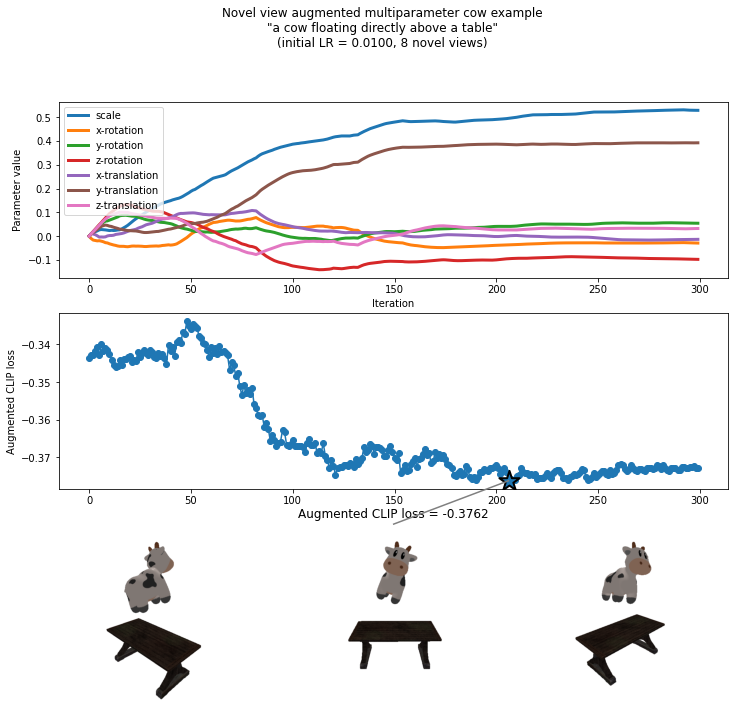

In [ ]:
fig = plt.figure(figsize=(12,11))

plt.subplot(3,1,1)
for s_v,label in zip(s_values.T, renderer.param_names):
  plt.plot(epochs, s_v, label=label, lw=3)
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

plt.subplot(3,1,2)
i_opt = np.argmin(gd_losses)
plt.plot(epochs, gd_losses, 'o-')
plt.scatter(epochs[i_opt], gd_losses[i_opt], marker='*', edgecolor='black', linewidth=2, s=450, zorder=5)
#plt.xlabel('Iteration')
plt.ylabel('Augmented CLIP loss')
ax_loss = plt.gca()

for i,j in enumerate([2,0,4]):
  plt.subplot(3,3,6+i+1)
  im_opt = renderer_class(s=s_values[i_opt]).to(device)(C_params)[j]
  plt.imshow(im_opt.permute((1,2,0)).detach().cpu())
  plt.axis('off')
  if j == 0:
    plt.title('Augmented CLIP loss = %.4f' % gd_losses[i_opt])
    ax_im = plt.gca()

transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(ax_loss.transData.transform([epochs[i_opt], gd_losses[i_opt]]))
coord2 = transFigure.transform(ax_im.transData.transform([im_opt.shape[2]/2, 0]))
line = lines.Line2D(
    (coord1[0], coord2[0]),  # xdata
    (coord1[1], coord2[1]),  # ydata
    transform=fig.transFigure,
    color="grey",
    zorder=1
)
fig.lines.append(line)

plt.suptitle(
    'Novel view augmented multiparameter cow example\n'
    '"%s"\n'
    r'(initial LR = %.4f, %d novel views)' % (text_prompts[0], lr, len(C_params))
    , y=1.0)
#plt.tight_layout()
plt.savefig('figs/3_3-loss-graph-aug.pdf', bbox_inches='tight')
plt.show()

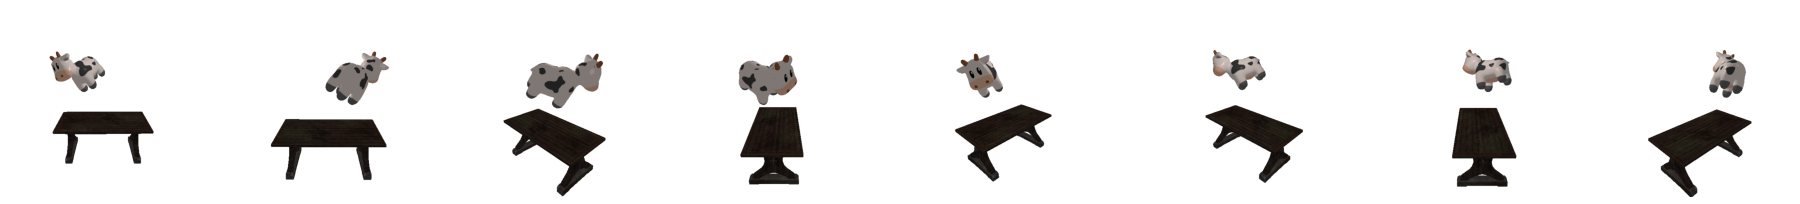

In [ ]:
renderer_class(s=s_values[i_opt]).to(device).debug(C_params)

# GIF fun

In [ ]:
from PIL import ImageDraw
from PIL import ImageFont
from IPython.display import Image as IPImage

for score,im_to_modify in zip(gd_losses, images_for_gif):
  draw = ImageDraw.Draw(im_to_modify)
  draw.text((im_to_modify.size[1] // 2 - 50, 35), "CLIP loss = %.3f" % score, (0,0,0),)

images_for_gif += [images_for_gif[-1]] * 15

frame_one = images_for_gif[0]
frame_one.save("room-multiparam.gif", format="GIF", append_images=images_for_gif,
            save_all=True, duration=30, loop=0)

IPImage(open('room-multiparam.gif','rb').read())

# Brute force searching bonanza

In [ ]:
g = 2 # granularity

print('Brute forcing %d parameter combinations' % 7**g)

grid_losses = np.zeros([g]*7)
S0 = np.linspace(-2,2,g)
S1 = np.linspace(-2,2,g)
S2 = np.linspace(-2,2,g)
S3 = np.linspace(-2,2,g)
S4 = np.linspace(-2,2,g)
S5 = np.linspace(-2,2,g)
S6 = np.linspace(-2,2,g)

t = tqdm(total=7**g, desc='Brute force search')
for i0,s0 in enumerate(S0):
  for i1,s1 in enumerate(S1):
    for i2,s2 in enumerate(S2):
      for i3,s3 in enumerate(S3):
        for i4,s4 in enumerate(S4):
          with torch.no_grad():
            batch_images = torch.stack([
              CowRenderer(s=[s0,s1,s2,s3,s4,s5,s6]).to(device)()[0]
              for s5 in S5
              for s6 in S6
            ])
            image_features = model.encode_image(p(batch_images))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            batch_losses = torch.squeeze(-text_features_norm@image_features.T).reshape((len(S5),len(S6))).cpu()
            grid_losses[i0,i1,i2,i3,i4,:,:] = batch_losses
            

        del image_features
        del batch_images
        torch.cuda.empty_cache()

Brute forcing 49 parameter combinations


Brute force search: 0it [00:00, ?it/s]

# Example images

In [ ]:
fig = plt.figure(figsize=(8,8))

with torch.no_grad():
  for idx,im in zip([1,3], CowRendererSingle(0).to(device)([(4,-10,180), (4,-10,90)])):
    plt.subplot(2,2,idx)
    plt.imshow(im.cpu().permute((1,2,0)))
    plt.title('s = %.2f' % 0.0)
    plt.axis('off')

  s_mod = 1
  for idx,im in zip([2,4], CowRendererSingle(s_mod).to(device)([(4,-10,180), (4,-10,90)])):
    plt.subplot(2,2,idx)
    plt.title('s = %.2f' % s_mod)
    plt.imshow(im.cpu().permute((1,2,0)))
    plt.axis('off')

plt.tight_layout()
plt.savefig('figs/3_3-cow-perspectives.pdf', bbox_inches='tight')
plt.show()

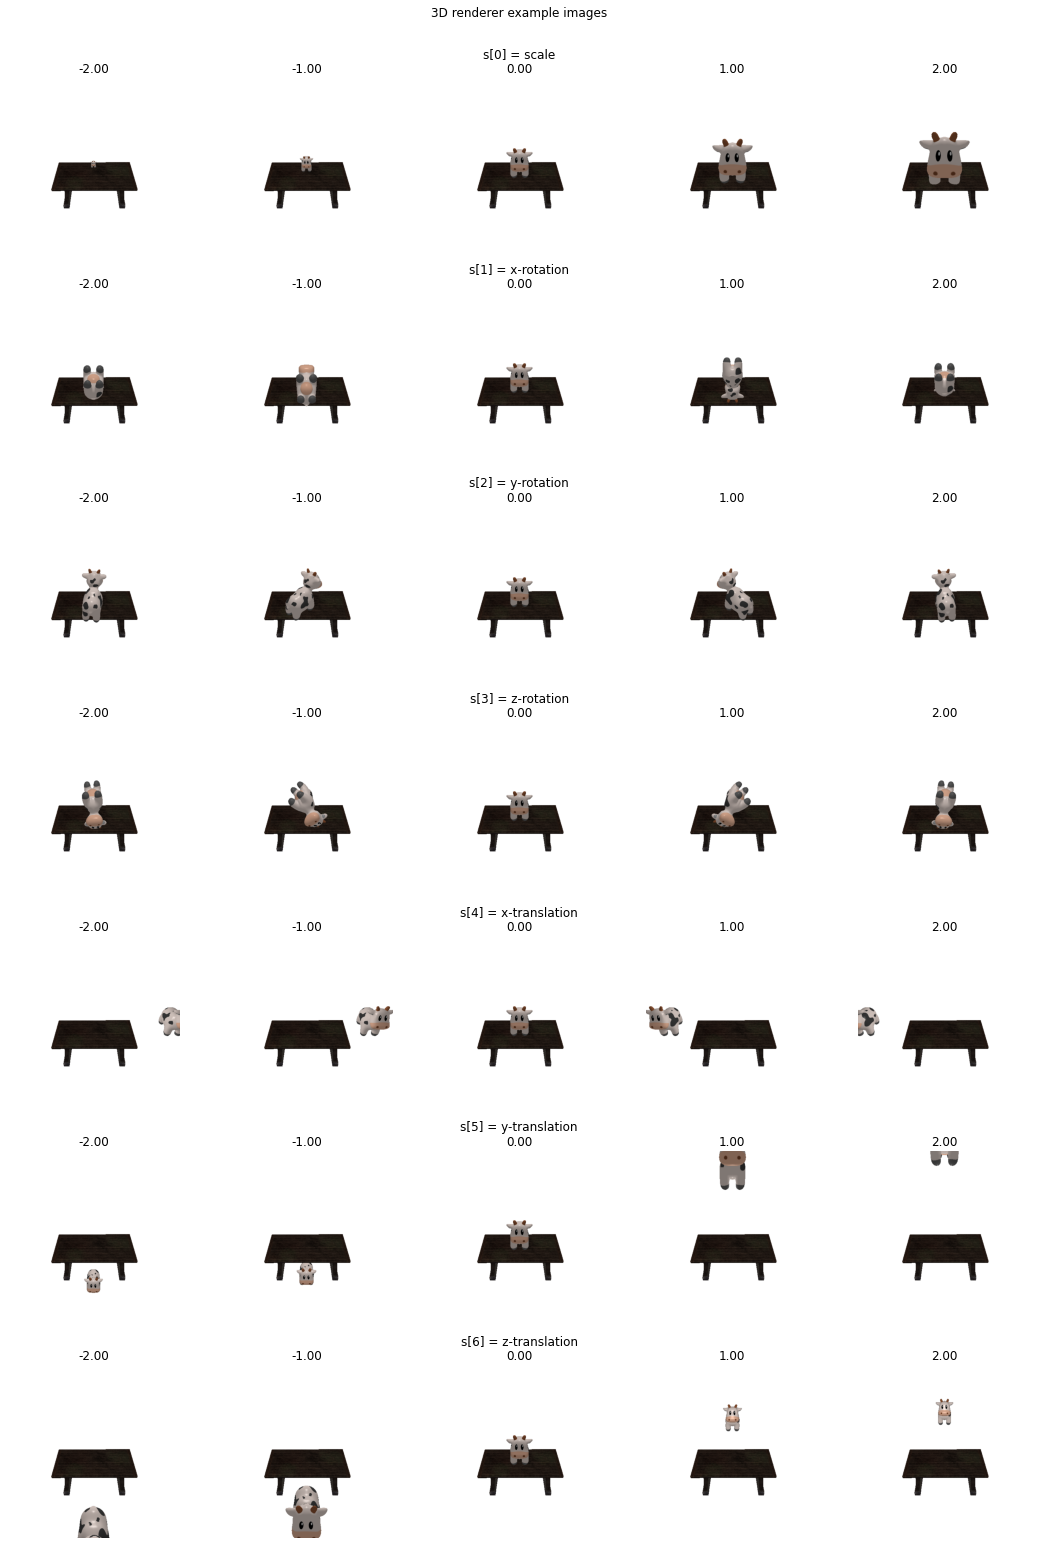

In [ ]:
rows = 7 # parameter count
cols = 5 # granularity
im_size = 3
fig = plt.figure(figsize=(im_size*cols, im_size*rows))

for i in range(rows):
  examples = np.zeros((cols,rows))
  examples[:,i] = np.linspace(-2,2,cols)
  for j,s_example in enumerate(examples):
    plt.subplot(rows,cols, i*cols+j+1)
    im_example = CowRenderer(s_example).to(device)()[0].detach().cpu().permute((1,2,0))
    plt.imshow(im_example)
    plt.axis('off')
    if j == np.ceil(len(examples)/2)-1:
      plt.title('s[%d] = %s\n%.2f' % (i, CowRenderer().param_names[i], s_example[i]))
    else:
      plt.title('\n%.2f' % s_example[i])

plt.tight_layout()
plt.suptitle('3D renderer example images', y=1.02)
plt.savefig('figs/3_3-example-images.pdf', bbox_inches='tight')
plt.show()